In [43]:
import squigglepy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from squigglepy.numbers import K, M, B

sq.set_seed(42)
np.random.seed(42)
N_SAMPLES = 5000
H100_TOPS = 1979

# ==================
# Helper functions
# ==================

def normalize_shares(raw_shares):
    """Normalize share values to sum to 1."""
    total = sum(raw_shares.values())
    return {k: v / total for k, v in raw_shares.items()}


def compute_h100_equivalents(chip_counts, chip_specs, h100_tops=1979):
    """Convert chip counts to H100 equivalents based on 8-bit TOPS."""
    return {
        version: counts * (chip_specs[version]['tops'] / h100_tops)
        for version, counts in chip_counts.items()
    }


def print_cumulative_summary(cumulative, chip_specs, title="Cumulative Production"):
    """Print formatted summary of cumulative chip counts with percentiles."""
    print(f"\n{title}")
    print(f"{'Version':<12} {'p5':>12} {'p50':>12} {'p95':>12}")
    print("-" * 51)

    grand_total = None
    for version in chip_specs:
        arr = cumulative[version]
        if arr.sum() > 0:
            if grand_total is None:
                grand_total = np.zeros_like(arr)
            grand_total += arr
            print(f"{version:<12} {int(np.percentile(arr, 5)):>12,} {int(np.percentile(arr, 50)):>12,} {int(np.percentile(arr, 95)):>12,}")

    if grand_total is not None:
        print("-" * 51)
        print(f"{'TOTAL':<12} {int(np.percentile(grand_total, 5)):>12,} {int(np.percentile(grand_total, 50)):>12,} {int(np.percentile(grand_total, 95)):>12,}")

In [44]:
# ===============================
# Core quarterly simulation logic
# ===============================
def estimate_chip_sales(quarters, versions, sample_revenue, sample_shares, sample_price, n_samples=5000):
    """
    Run Monte Carlo simulation to estimate chip volumes.

    Args:
        quarters: list of quarter identifiers
        versions: list of chip versions
        sample_revenue: fn(quarter) -> float, samples or retrieves quarterly revenue in dollars
        sample_shares: fn(quarter) -> dict {version: share}, should sum to 1
        sample_price: fn(quarter, version) -> float, samples price of chip version for given quarter
        n_samples: number of Monte Carlo samples

    Returns:
        dict of {quarter: {version: list of chip counts}}
    """
    results = {quarter: {version: [] for version in versions} for quarter in quarters}

    for _ in range(n_samples):
        for quarter in quarters:
            revenue = sample_revenue(quarter)
            shares = sample_shares(quarter)

            for version in versions:
                share = shares.get(version, 0)
                if share > 0:
                    price = sample_price(quarter, version)
                    chips = (revenue * share) / price
                else:
                    chips = 0
                results[quarter][version].append(chips)

    return results

In [45]:
# NVIDIA chip specs: 8-bit TFLOP/s
CHIP_SPECS = {
    'A100':      {'tops': 624},
    'A800':      {'tops': 624},
    'H100/H200': {'tops': 1979},
    'H800':      {'tops': 1979},
    'H20':       {'tops': 296},
    'B200':      {'tops': 5000},
    'B300':      {'tops': 5000},
}
CHIP_TYPES = list(CHIP_SPECS.keys())

# Colors for visualization
CHIP_COLORS = {
    'A100': 'lightcoral',
    'A800': 'sienna',
    'H100/H200': 'steelblue',
    'H800': 'firebrick',
    'H20': 'orange',
    'B200': 'mediumseagreen',
    'B300': 'seagreen',
}

# Hardware share of compute revenue (vs cloud/software)
HARDWARE_SHARE = sq.to(0.96, 0.99, credibility=80)

In [46]:
# Load revenue and price data from Google Sheets
revenue_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=0"
).set_index('Quarter')

prices_df = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/1Yhu87Rw--9tviAuBwg_luL3OFAFkdHdVfli6tN215Xk/export?format=csv&gid=1819303346"
).set_index('Year')

print(f"Loaded {len(revenue_df)} quarters of revenue data")
print(f"Loaded {len(prices_df)} years of price data")
revenue_df[['Compute revenue'] + [f'{chip} share' for chip in CHIP_TYPES]].head()

Loaded 15 quarters of revenue data
Loaded 4 years of price data


,Compute revenue,A100 share,A800 share,H100/H200 share,H800 share,H20 share,B200 share,B300 share
Quarter,,,,,,,,
FY23Q1,2.81,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q2,2.86,1.00,0.00,0.0,0.0,0.0,0.0,0.0
FY23Q3,2.87,0.90,0.00,0.1,0.0,0.0,0.0,0.0
FY23Q4,2.72,0.31,0.19,0.5,0.0,0.0,0.0,0.0
FY24Q1,3.35,0.21,0.09,0.6,0.1,0.0,0.0,0.0


In [47]:
prices_df.head(20)

,A100 low,A100 high,Notes,H100 low,H100 high,Geomean,Notes.1,B200 low,B200 high,Geomean.1,...,Geomean.2,Notes.3,H20 low,H20 high,Geomean.3,A800 low,A800 high,Notes.4,H800 low,H800 high
Year,,,,,,,,,,,,,,,,,,,,,
2022,10000,15000,NaN,25000,35000,"$29,580",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,NaN,NaN,NaN
2023,10000,15000,NaN,25000,35000,"$29,580",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10000.0,15000.0,NaN,25000.0,35000.0
2024,10000,15000,NaN,23000,30000,"$26,268",NaN,33000.0,42000.0,"$37,229",...,NaN,NaN,10000.0,15000.0,"$12,247",NaN,NaN,NaN,NaN,NaN
2025,10000,15000,NaN,20000,27000,"$23,238",NaN,33000.0,42000.0,"$37,229",...,"$43,151",NaN,10000.0,13000.0,"$11,402",NaN,NaN,NaN,NaN,NaN


In [48]:
def fy_to_decimal_year(fy_string):
    """
    Convert NVIDIA fiscal year quarter string to decimal year.
    NVIDIA FY ends in January: FY26Q1 ends Apr 2025, FY26Q4 ends Jan 2026.
    """
    fy_num = int(fy_string[2:4])
    quarter = int(fy_string[5])
    fiscal_year = 2000 + fy_num
    
    # Q4 is in fiscal year, Q1-Q3 are in fiscal_year - 1
    if quarter == 4:
        calendar_year = fiscal_year
    else:
        calendar_year = fiscal_year - 1
    
    # Decimal fraction for quarter end
    quarter_fractions = {1: 0.32, 2: 0.57, 3: 0.82, 4: 0.07}
    return calendar_year + quarter_fractions[quarter]


def fy_to_calendar_year(fy_string):
    """Convert NVIDIA fiscal year quarter to calendar year for price lookup."""
    return int(fy_to_decimal_year(fy_string))  # floor, not round


# Map chip types to their column names in the prices CSV
# (CSV uses "H100" not "H100/H200")
PRICE_COLUMN_MAP = {
    'H100/H200': 'H100',
}

def get_price_distribution(chip_type, year):
    """Get price distribution for a chip type in a given year."""
    available_years = prices_df.index.tolist()
    closest_year = min(available_years, key=lambda y: abs(y - year))
    
    # Map chip type to CSV column name (e.g., H100/H200 -> H100)
    csv_chip_name = PRICE_COLUMN_MAP.get(chip_type, chip_type)
    
    low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'
    if low_col in prices_df.columns and high_col in prices_df.columns:
        low = prices_df.loc[closest_year, low_col]
        high = prices_df.loc[closest_year, high_col]
        if pd.notna(low) and pd.notna(high):
            return sq.to(low, high, credibility=80)
    
    # Fallback prices
    fallbacks = {'A100': (10*K, 15*K), 'A800': (10*K, 15*K), 'H100/H200': (20*K, 30*K),
                 'H800': (20*K, 30*K), 'H20': (10*K, 15*K), 'B200': (33*K, 42*K), 'B300': (33*K, 42*K)}
    return sq.to(*fallbacks.get(chip_type, (20*K, 30*K)), credibility=80)

In [ ]:
# ======================================================================
# Sampling functions for quarter revenue, chip type shares, and chip price
# These get fed into the monte carlo
# ======================================================================

# Pre-compute price distributions by quarter and chip type
QUARTERS = revenue_df.index.tolist()
PRICE_DISTS = {}
for quarter in QUARTERS:
    year = fy_to_calendar_year(quarter)
    PRICE_DISTS[quarter] = {chip: get_price_distribution(chip, year) for chip in CHIP_TYPES}


def sample_revenue(quarter):
    # retrieve compute revenue for a quarter, multiply by one sample from hardware share
    base_revenue = revenue_df.loc[quarter, 'Compute revenue'] * B
    return base_revenue * (HARDWARE_SHARE @ 1)

def sample_shares(quarter):
    return {chip: revenue_df.loc[quarter, f'{chip} share'] for chip in CHIP_TYPES}

def sample_price(quarter, version):
    # sample one price for chip type in given quarter
    return PRICE_DISTS[quarter][version] @ 1

In [ ]:
# =============================================================================
# Summary of input parameters for debugging
# =============================================================================

# Revenue by quarter
print("=== QUARTERLY REVENUE ($ Billions) ===")
print(revenue_df[['Compute revenue']].to_string())

print("\n=== CHIP SHARES BY QUARTER ===")
share_cols = [f'{chip} share' for chip in CHIP_TYPES]
print(revenue_df[share_cols].to_string())

print("\n=== PRICE DISTRIBUTIONS BY YEAR (from CSV) ===")
for year in prices_df.index:
    print(f"\n{year}:")
    for chip in CHIP_TYPES:
        csv_chip_name = PRICE_COLUMN_MAP.get(chip, chip)
        low_col, high_col = f'{csv_chip_name} low', f'{csv_chip_name} high'
        if low_col in prices_df.columns and high_col in prices_df.columns:
            low = prices_df.loc[year, low_col]
            high = prices_df.loc[year, high_col]
            if pd.notna(low) and pd.notna(high):
                print(f"  {chip}: ${low:,.0f} - ${high:,.0f}")
            else:
                print(f"  {chip}: (no data, using fallback)")
        else:
            print(f"  {chip}: (no column, using fallback)")

print("\n=== QUARTER -> YEAR MAPPING (for price lookup) ===")
for q in revenue_df.index:
    decimal = fy_to_decimal_year(q)
    year = fy_to_calendar_year(q)
    print(f"  {q}: decimal={decimal:.2f} -> year={year}")

=== QUARTERLY REVENUE ($ Billions) ===
         Compute revenue
Quarter                 
FY23Q1              2.81
FY23Q2              2.86
FY23Q3              2.87
FY23Q4              2.72
FY24Q1              3.35
FY24Q2              8.61
FY24Q3             11.90
FY24Q4             15.07
FY25Q1             19.44
FY25Q2             22.62
FY25Q3             27.66
FY25Q4             32.57
FY26Q1             34.13
FY26Q2             33.87
FY26Q3             43.01

=== CHIP SHARES BY QUARTER ===
         A100 share  A800 share  H100/H200 share  H800 share  H20 share  B200 share  B300 share
Quarter                                                                                        
FY23Q1         1.00        0.00             0.00        0.00       0.00        0.00        0.00
FY23Q2         1.00        0.00             0.00        0.00       0.00        0.00        0.00
FY23Q3         0.90        0.00             0.10        0.00       0.00        0.00        0.00
FY23Q4         0.31     

In [51]:
# Run simulation to estimate chip sales for each chip type and quarter
# Note: estimate_chip_sales samples independently for each quarter, so cross-quarter
# correlations (e.g., shared price assumptions across quarters) are NOT preserved.

sim_results = estimate_chip_sales(
    quarters=QUARTERS,
    versions=CHIP_TYPES,
    sample_revenue=sample_revenue,
    sample_shares=sample_shares,
    sample_price=sample_price,
    n_samples=N_SAMPLES
)

In [52]:
# Quarterly summary by chip type: units and H100-equivalents
print("=== QUARTERLY CHIP SALES BY TYPE ===\n")

for chip in CHIP_TYPES:
    # Check if this chip has any sales
    has_sales = any(np.array(sim_results[q][chip]).sum() > 0 for q in QUARTERS)
    if not has_sales:
        continue
    
    print(f"--- {chip} ---")
    print(f"{'Quarter':<10} {'Units (p50)':>12} {'Units (90% CI)':>24} {'H100e (p50)':>12} {'H100e (90% CI)':>24}")
    
    for quarter in QUARTERS:
        arr = np.array(sim_results[quarter][chip])
        if arr.sum() > 0:
            h100e_arr = arr * (CHIP_SPECS[chip]['tops'] / H100_TOPS)
            u_p5, u_p50, u_p95 = [int(np.percentile(arr, p)) for p in [5, 50, 95]]
            h_p5, h_p50, h_p95 = [int(np.percentile(h100e_arr, p)) for p in [5, 50, 95]]
            print(f"{quarter:<10} {u_p50:>12,} {f'({u_p5:,} - {u_p95:,})':>24} {h_p50:>12,} {f'({h_p5:,} - {h_p95:,})':>24}")
    print()

=== QUARTERLY CHIP SALES BY TYPE ===

--- A100 ---
Quarter     Units (p50)           Units (90% CI)  H100e (p50)           H100e (90% CI)
FY23Q1          223,929      (172,026 - 290,414)       70,607        (54,241 - 91,570)
FY23Q2          227,562      (174,076 - 295,281)       71,752        (54,888 - 93,105)
FY23Q3          205,390      (158,439 - 266,824)       64,761        (49,957 - 84,132)
FY23Q4           66,879        (51,308 - 87,075)       21,087        (16,178 - 27,455)
FY24Q1           55,883        (43,257 - 72,693)       17,620        (13,639 - 22,921)
FY24Q2           68,419        (52,665 - 89,278)       21,573        (16,606 - 28,150)
FY24Q3           47,479        (36,321 - 61,964)       14,970        (11,452 - 19,538)

--- A800 ---
Quarter     Units (p50)           Units (90% CI)  H100e (p50)           H100e (90% CI)
FY23Q4           41,268        (31,541 - 53,624)       13,012         (9,945 - 16,908)
FY24Q1           24,015        (18,479 - 31,276)        7,572    

In [53]:
# Cumulative totals by chip type
cumulative = {chip: np.zeros(N_SAMPLES) for chip in CHIP_TYPES}
for quarter in sim_results:
    for chip in CHIP_TYPES:
        cumulative[chip] += np.array(sim_results[quarter][chip])

print_cumulative_summary(cumulative, CHIP_SPECS, "Cumulative NVIDIA Chip Sales (FY23-FY27)")


Cumulative NVIDIA Chip Sales (FY23-FY27)
Version                p5          p50          p95
---------------------------------------------------
A100              807,356      903,585    1,019,327
A800              106,837      122,235      139,749
H100/H200       4,490,398    4,783,962    5,108,825
H800              101,502      116,975      134,840
H20             1,393,385    1,533,008    1,680,437
B200            1,481,309    1,606,635    1,741,969
B300              832,506      939,363    1,062,706
---------------------------------------------------
TOTAL           9,632,311   10,017,949   10,424,742


In [54]:
# H100 equivalents
h100_eq = compute_h100_equivalents(cumulative, CHIP_SPECS, H100_TOPS)
print_cumulative_summary(h100_eq, CHIP_SPECS, "H100 Equivalents (8-bit TOPS basis)")


H100 Equivalents (8-bit TOPS basis)
Version                p5          p50          p95
---------------------------------------------------
A100              254,568      284,910      321,404
A800               33,686       38,542       44,064
H100/H200       4,490,398    4,783,962    5,108,825
H800              101,502      116,975      134,840
H20               208,409      229,292      251,343
B200            3,742,571    4,059,210    4,401,135
B300            2,103,351    2,373,327    2,684,959
---------------------------------------------------
TOTAL          11,369,675   11,902,335   12,455,029


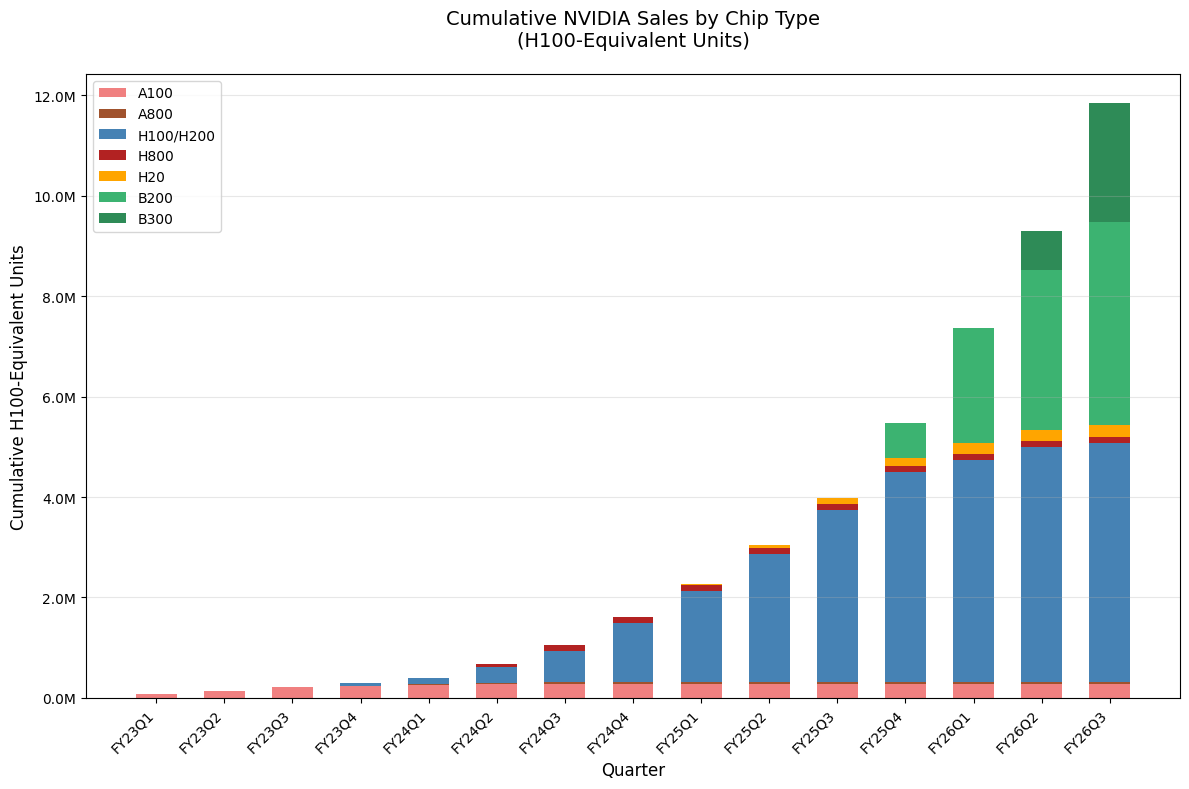

In [55]:
# Cumulative NVIDIA Sales by Chip Type (H100-equivalent units)
quarters = list(sim_results.keys())

# Get median values for each chip type, converted to H100-equivalents
chip_medians = {}
for chip in CHIP_TYPES:
    quarterly_medians = [np.median(sim_results[q][chip]) for q in quarters]
    h100e_ratio = CHIP_SPECS[chip]['tops'] / H100_TOPS
    chip_medians[chip] = np.array(quarterly_medians) * h100e_ratio

# Calculate cumulative sums
chip_cumulative = {chip: np.cumsum(chip_medians[chip]) for chip in CHIP_TYPES}

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(quarters))
width = 0.6

bottom = np.zeros(len(quarters))
for chip in CHIP_TYPES:
    ax.bar(x, chip_cumulative[chip], width, label=chip, bottom=bottom, color=CHIP_COLORS[chip])
    bottom += chip_cumulative[chip]

ax.set_ylabel('Cumulative H100-Equivalent Units', fontsize=12)
ax.set_xlabel('Quarter', fontsize=12)
ax.set_title('Cumulative NVIDIA Sales by Chip Type\n(H100-Equivalent Units)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(quarters, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()